In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [75]:
import os
import numpy as np
import cv2
import zipfile
import requests
import glob as glob

import tensorflow_hub as hub
import matplotlib
import matplotlib.pyplot as plt
import warnings
import logging
import absl

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import os
print(os.listdir('/kaggle/input/coco-2017-dataset/coco2017/val2017'))

In [77]:
import os
import glob

# Path to test set
test_path = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
images = glob.glob(os.path.join(test_path, '**', '*.*'), recursive=True)
valid_exts = {'.jpg', '.jpeg', '.png'}
images = [img for img in images if os.path.splitext(img)[1].lower() in valid_exts]
print(f"Total images found: {len(images)}")
if images:
    print(f"Example image path: {images[0]}")
else:
    print("No images found. Check your dataset path or extensions.")

Total images found: 5000
Example image path: /kaggle/input/coco-2017-dataset/coco2017/val2017/000000011197.jpg


In [78]:
def load_image(path):
    image=cv2.imread(path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=np.expand_dims(image,axis=0)
    return image

In [ ]:
import random
sample_images=random.sample(images,5)

fig,ax =plt.subplots(nrows=2,ncols=2,figsize=(20,14))
for axis,image_path in zip(ax.flat,sample_images):
    image=load_image(image_path)
    axis.imshow(image[0])
    axis.axis('off')
    axis.set_title(os.path.basename(image_path))
plt.show()

In [80]:
class_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'
}

In [81]:
#Color Palatte
R = np.array(np.arange(96, 256, 32))
G = np.roll(R, 1)
B = np.roll(R, 2)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

In [82]:
EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }
model_url = EfficientDet['EfficientDet D4 1024x1024' ]

print('loading model: ', model_url)
od_model = hub.load(model_url)

print('\nmodel loaded!')

loading model:  https://tfhub.dev/tensorflow/efficientdet/d4/1

model loaded!


In [84]:
model_image = load_image(sample_images[0])  # Shape (1,H,W,3)
results = od_model(model_image)  # Pass the batched image directly
results = {key: value.numpy() for key, value in results.items()}

# Print the keys from the results dictionary
for key in results:
    print(key)

detection_anchor_indices
detection_boxes
detection_classes
detection_multiclass_scores
detection_scores
num_detections
raw_detection_boxes
raw_detection_scores


In [85]:
print("Raw Predictions of EfficientDet",(len(results['raw_detection_scores'][0])))
print('Valid Detections of EfficientDet:', (results['num_detections'][0]).astype(int))

Raw Predictions of EfficientDet 196416
Valid Detections of EfficientDet: 100


In [ ]:
num_dets = (results['num_detections'][0]).astype(int)
print('\nDetection Scores: \n\n', results['detection_scores'][0][0:num_dets])
print('\nDetection Classes: \n\n', results['detection_classes'][0][0:num_dets])
print('\nDetection Boxes: \n\n', results['detection_boxes'][0][0:num_dets])

In [91]:
def process_detection(image, results, min_score=0.3):
    # Step 1: Extract the Scores, Classes, Boxes
    scores = results['detection_scores'][0]
    boxes = results['detection_boxes'][0]
    classes = (results['detection_classes'][0]).astype(int)

    # Filter detections by minimum score
    filtered_indices = np.where(scores >= min_score)[0]
    filtered_scores = scores[filtered_indices]
    filtered_boxes = boxes[filtered_indices]
    filtered_classes = classes[filtered_indices]

    # Copy image to draw bounding boxes
    img_bbox = image.copy()
    image_height, image_width = image.shape[:2]

    font_scale = 0.4
    box_thickness = 2

    for box, class_id, score in zip(filtered_boxes, filtered_classes, filtered_scores):
        ymin, xmin, ymax, xmax = box

        # Convert normalized box coords to pixel coords
        left = int(xmin * image_width)
        right = int(xmax * image_width)
        top = int(ymin * image_height)
        bottom = int(ymax * image_height)

        class_name = class_index[class_id]  # Make sure class_index dict/list is defined
        color = tuple(COLOR_IDS[class_id % len(COLOR_IDS)].tolist())[::-1]  # Make sure COLOR_IDS is defined

        # Draw bounding box
        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=box_thickness)

        # Prepare label text
        display_txt = '{}: {:.2f}%'.format(class_name, 100 * score)

        # Get text size for background rectangle
        (text_width, text_height), baseline = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)

        # Determine if we need to shift text down if box is too close to top
        if top < text_height:
            shift_down = int(2 * (1.3 * text_height))
        else:
            shift_down = 0

        # Draw filled rectangle as background for text
        img_bbox = cv2.rectangle(
            img_bbox,
            (left - 1, top - box_thickness - int(1.3 * text_height) + shift_down),
            (left - 1 + int(1.1 * text_width), top + shift_down),
            color,
            thickness=-1
        )

        # Put text on top of the filled rectangle
        img_bbox = cv2.putText(
            img_bbox,
            display_txt,
            (left + int(0.05 * text_width), top - int(0.2 * text_height) + int(shift_down / 2)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (0, 0, 0),  # Black text color
            1
        )

    return img_bbox


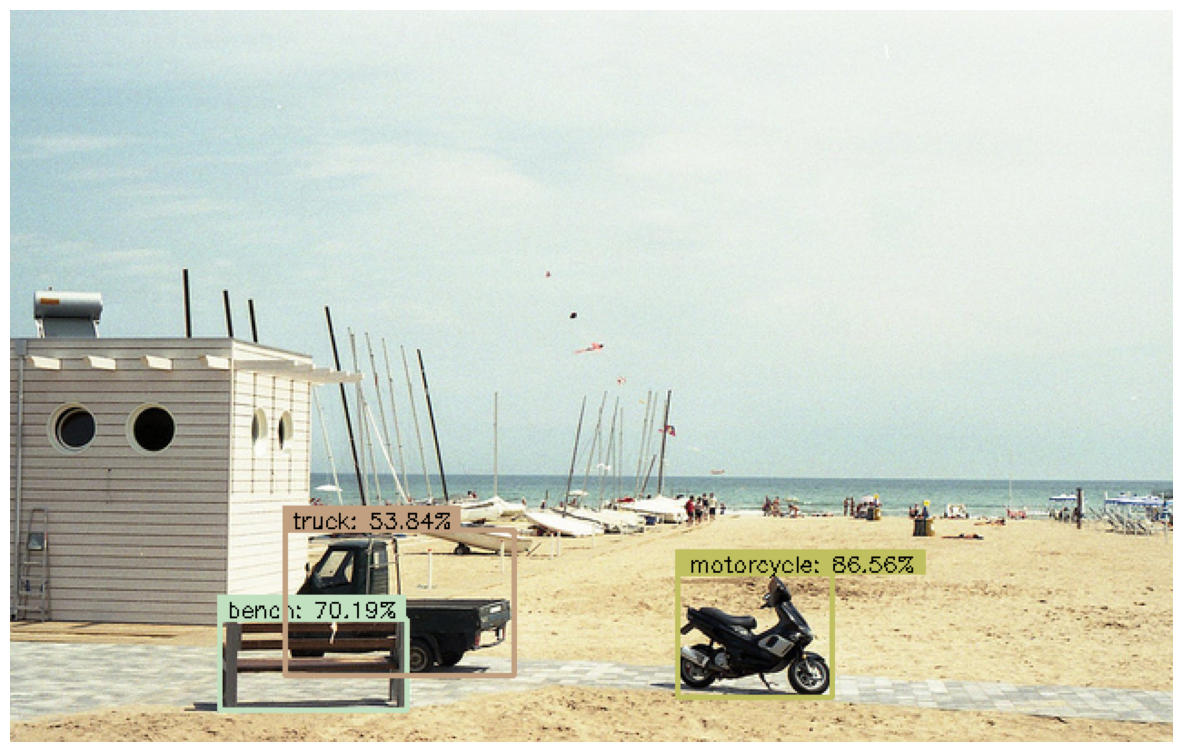

In [92]:
# Call the model.
results = od_model(model_image)

# Convert the dictionary values to numpy arrays.
results = {key:value.numpy() for key, value in results.items()}

# Remove the batch dimension from the first image.
image = np.squeeze(model_image,axis=0)

# Process the first sample image.
img_bbox = process_detection(image, results, min_score=0.5)

plt.figure(figsize=[15, 10])
plt.imshow(img_bbox)
plt.axis('off');

Now We will Write the Code for Run Inference that Runs our model for many images

['/kaggle/input/coco-2017-dataset/coco2017/val2017/000000089078.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000050165.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000312237.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000451150.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000187236.jpg']
<class 'str'>
<class 'numpy.ndarray'>


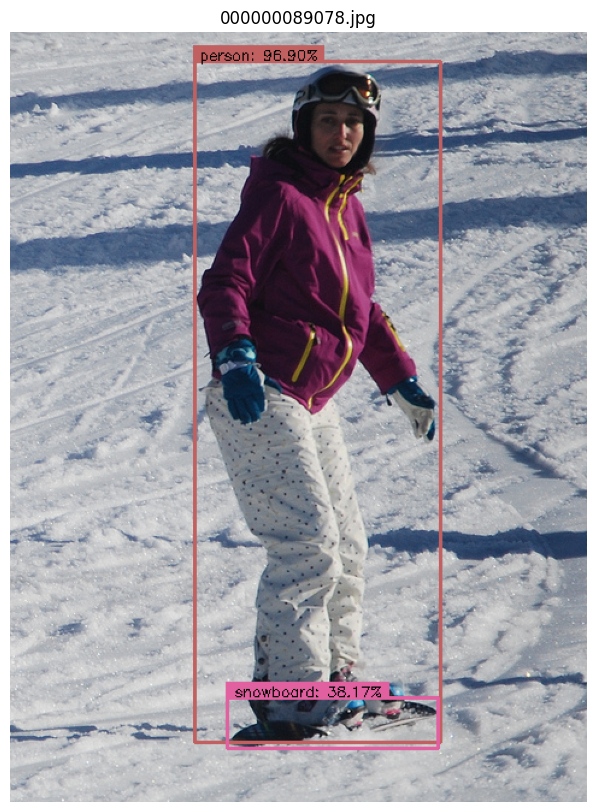

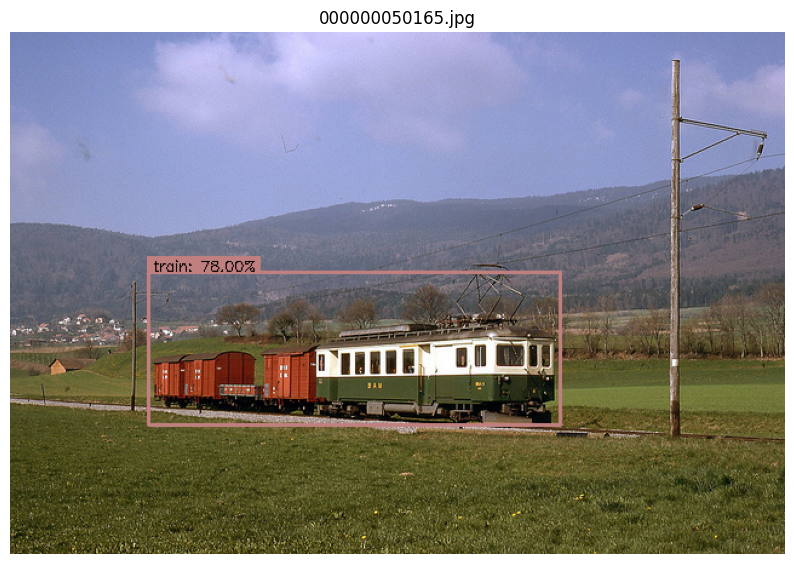

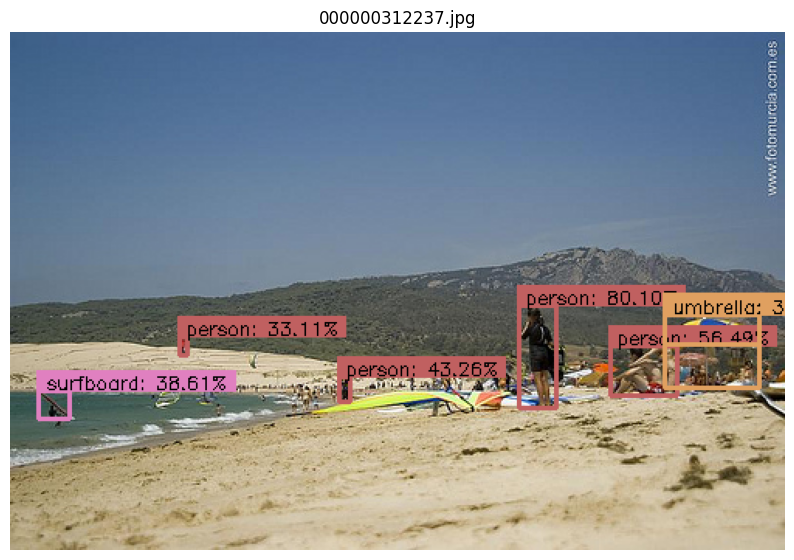

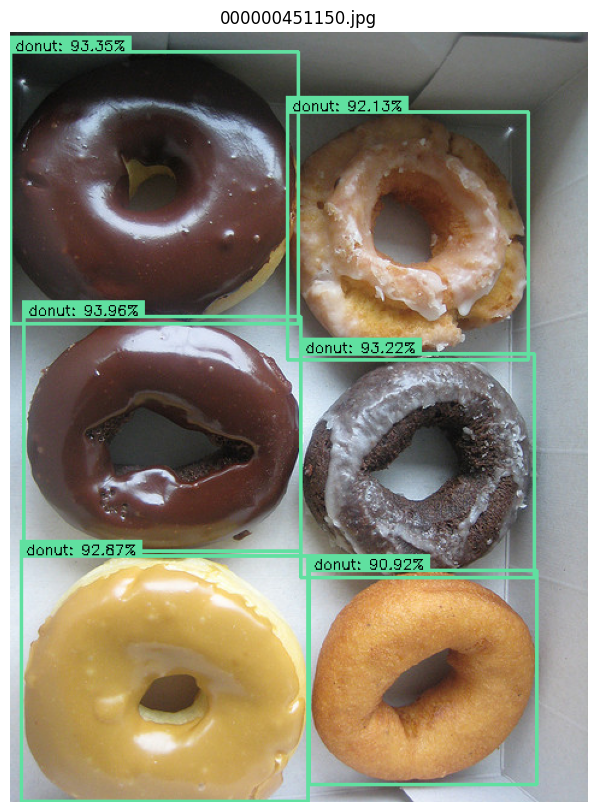

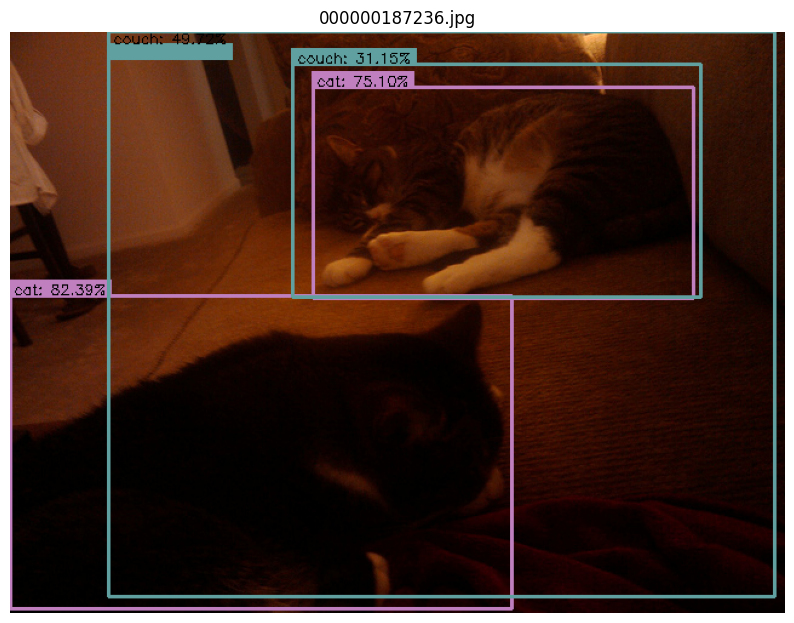

In [93]:
def run_inference(images, model):
    results_list = []
    for img in images:  # img shape (1,H,W,3)
        result = model(img)
        result = {key: value.numpy() for key, value in result.items()}
        results_list.append(result)
    return results_list



image_paths = images  


sample_image_paths = random.sample(image_paths, 5)

print(sample_image_paths)
print(type(sample_image_paths[0]))


images_loaded = [load_image(path) for path in sample_image_paths]

print(type(images_loaded[0]))  


results_list = run_inference(images_loaded, od_model)


for idx, result in enumerate(results_list):
    image = np.squeeze(images_loaded[idx], axis=0)  # remove batch dim
    image_bbox = process_detection(image, result, min_score=0.31)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_bbox)
    plt.axis('off')
    plt.title(os.path.basename(sample_image_paths[idx]))
    plt.show()

